In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [77]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import qutip as qt
from matplotlib import pyplot as plt

We also declare a 3-qubit simulator device running in Cirq.


In [4]:
dev = qml.device('cirq.simulator', wires=3)

Generator and Discriminator
===========================




In [22]:
def U1(w,wire):
    qml.RZ(w[0],wires = wire)
    qml.RX(w[1],wires = wire)
    qml.RZ(w[2],wires = wire)

def U2(w,wire1,wire2):
    U1(w[0:3], wire1)
    U1(w[3:6], wire2)
    qml.CNOT(wires = [wire2,wire1])
    qml.RZ(w[6],wires = wire1)
    qml.RY(w[7],wires = wire2)
    qml.CNOT(wires = [wire1,wire2])
    qml.RY(w[8],wires = wire2)
    qml.CNOT(wires = [wire2,wire1])
    U1(w[9:12], wire1)
    U1(w[12:15],wire2)

In [7]:
def real(w):
    U2(w,0,1)
    

def generator(w, **kwargs):
    U2(w[0:15],0,1)
    U2(w[15:30],0,1) #Erase this, be careful with overparametrization
    
def discriminator(w, **kwargs):
    U2(w[0:15],0,1)
    U2(w[15:30],1,2)
    U2(w[30:45],0,1)
    U2(w[45:60],1,2)

# Nodes

In [8]:
@qml.qnode(dev, interface="tf")
def real_disc_circuit(real_params, disc_weights):
    real(real_params)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))


@qml.qnode(dev, interface="tf")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

QGAN cost functions
===================




In [18]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(real_params, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights):
    cost = -prob_fake_true(gen_weights, disc_weights)
    return cost

Initializing the weights
=================


Real state generation

In [60]:
real_params = np.random.uniform(low=-np.pi, high=np.pi, size=15)

Generator and Discriminator parameter initialization

In [61]:
init_gen_weights = np.random.uniform(low=-np.pi, high=np.pi, size=30)

init_disc_weights = np.random.uniform(low=-np.pi, high=np.pi, size=60)

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

We begin by creating the optimizer:


In [17]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.05) #in another simulation they use 0.1 #AMSgrad = True

We train in turns. We expect around 250 turns to converge. Each turn consists of 5 discriminator steps and 1 generator step.

# Define some other metrics

In [30]:
dev_state = qml.device('default.qubit', wires=2)

In [33]:
@qml.qnode(dev_state, interface="tf")
def real_circuit(w):
    U1(w[0:3], 0)
    U1(w[3:6], 1)
    qml.CNOT(wires = [1,0])
    qml.RZ(w[6],wires = 0)
    qml.RY(w[7],wires = 1)
    qml.CNOT(wires = [0,1])
    qml.RY(w[8],wires = 1)
    qml.CNOT(wires = [1,0])
    U1(w[9:12], 0)
    U1(w[12:15],1)
    return qml.state()


@qml.qnode(dev_state, interface="tf")
def gen_circuit(gen_weights):
    generator(gen_weights)
    return qml.state()

In [44]:
def fidelity(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).numpy())
    
    ρ_R = real_state * real_state.dag()
    ρ_G = gen_state * gen_state.dag()
    
    F = qt.fidelity(ρ_R,ρ_G)
    return F

In [48]:
def trace_distance(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).numpy())
    
    ρ_R = real_state * real_state.dag()
    ρ_G = gen_state * gen_state.dag()
    
    d = qt.tracedist(ρ_R,ρ_G)
    return d

------------------------------------------------------------------------------

# Training routine

In [64]:
#----- Metrics ----------------------------

Disc_cost = [] # P(R|R)-P(R|G)
Gen_cost = [] # P(R|G)
Trace_d = [] #Trace distance
F = [] #Fidelity

#-------------------------------------------

costD = lambda: disc_cost(disc_weights)
costG = lambda: gen_cost(gen_weights)

for turn in range(50):
    for step in range(5): #The actual ratio should be 20 to 1, according to what we discussed
        opt.minimize(costD, disc_weights)
        if step == 4:
            costD_val = costD().numpy()
            #print("Step {}: cost = {}".format(step, costD_val))
            Disc_cost += [-costD_val] # P(R|R)-P(R|G)
        
    opt.minimize(costG, gen_weights)
    costG_val = costG().numpy()
    #print("Step {}: cost = {}".format(step, costG_val))
    Gen_cost += [-costG_val] # P(R|G)
    
    fid = fidelity(real_params,gen_weights)
    F += [fid] #Fidelity
    
    TrD = trace_distance(real_params,gen_weights)
    Trace_d += [TrD] #Trace distance
    
    print("P(R|R)-P(R|G): ", -costD_val)
    print("P(R|G): ", -costG_val)
    print("Fidelity: ",fid)
    print("Trace distance: ",TrD)
    print("------------------------------")
    

P(R|R)-P(R|G):  0.15458284318447113
P(R|G):  0.5585718750953674
Fidelity:  0.9472625335531828
Trace distance:  0.32045857938513217
------------------------------
P(R|R)-P(R|G):  0.0952494740486145
P(R|G):  0.37602733075618744
Fidelity:  0.7916055178495006
Trace distance:  0.6110324980523325
------------------------------
P(R|R)-P(R|G):  0.4144642800092697
P(R|G):  0.3132867068052292
Fidelity:  0.7011446580514539
Trace distance:  0.7130190580481793
------------------------------
P(R|R)-P(R|G):  0.5760569795966148
P(R|G):  0.2743462175130844
Fidelity:  0.6964966378258927
Trace distance:  0.7175600668818546
------------------------------
P(R|R)-P(R|G):  0.6777355968952179
P(R|G):  0.2950580418109894
Fidelity:  0.7518943967108269
Trace distance:  0.6592835726095451
------------------------------
P(R|R)-P(R|G):  0.6180434823036194
P(R|G):  0.3951454907655716
Fidelity:  0.8307933397053765
Trace distance:  0.5565810363843907
------------------------------
P(R|R)-P(R|G):  0.5193582773208618
P(

In [70]:
F = np.array(F)
Gen_cost = np.array(Gen_cost)
Disc_cost = np.array(Disc_cost)
Trace_d = np.array(Trace_d)

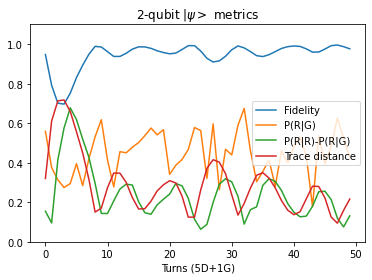

In [90]:
plt.plot(F, label='Fidelity')
plt.plot(Gen_cost, label='P(R|G)')
plt.plot(Disc_cost, label='P(R|R)-P(R|G)')
plt.plot(Trace_d, label='Trace distance')
plt.ylim([0,1.1])
plt.xlabel('Turns (5D+1G)') 
plt.title("2-qubit $|\psi>$ metrics")
plt.legend()
plt.savefig('2qubitlearning.png', format='png')

In [26]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

bloch_vector_real = qml.map(real, obs, dev, interface="tf")
bloch_vector_generator = qml.map(generator, obs, dev, interface="tf")

print("Real Bloch vector: {}".format(bloch_vector_real([phi, theta, omega])))
print("Generator Bloch vector: {}".format(bloch_vector_generator(gen_weights)))

Real Bloch vector: [0.99999988 0.         0.        ]
Generator Bloch vector: [ 0.44972545 -0.88693075  0.10536051]
